In [1]:

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

import datetime

def categorize(x):
    if x <= 30: return 0
    elif x <= 50: return 1
    else: return 2

def preprocess_3h(df):

    x = df.copy()

    x['category'] = x['Kp*10'].apply(categorize)

    x['dttm'] = x.apply(
        lambda y: datetime.datetime(
            int(y.year), int(y.month), 
            int(y.day), int(y['hour from']), 0), axis=1)
    
    x_3h = x.sort_values(by='dttm').iloc[:: 3]
    return x_3h

ROOT_PATH = '/content/drive/MyDrive/kp_data'

import os
import glob

files = glob.glob(os.path.join(ROOT_PATH, '*'))

files = dict(map(lambda x: (x.split('/')[-1], x), files))

df = pd.read_csv(
    files['All_browse_data_без_погружения_19971021_20211231_с_пропусками.csv'], 
    encoding='cp1251', na_values='N').pipe(preprocess_3h)
print(df.shape)
df.head()

(70776, 65)


,year,month,day,hour from,hour to,doySin,hourSin,doyCos,hourCos,Dst,...,lg(E>2 MeV),E>2 MeV G16,lg(E>2 MeV) G16,CH_rca (193),CH_rca (211),SW_spd_frcst (193),SW_spd_frcst (211),Unnamed: 62,category,dttm
0,1997,10,21,0,1,-0.505271,0.991445,-0.862961,-0.130526,-14,...,0.715307,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1997-10-21 00:00:00
3,1997,10,21,3,4,-0.507126,0.608761,-0.861872,-0.793353,-13,...,0.318573,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1997-10-21 03:00:00
6,1997,10,21,6,7,-0.508980,-0.130526,-0.860779,-0.991445,-15,...,0.070838,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1997-10-21 06:00:00
9,1997,10,21,9,10,-0.510831,-0.793353,-0.859681,-0.608761,-13,...,0.501584,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1997-10-21 09:00:00
12,1997,10,21,12,13,-0.512679,-0.991445,-0.858580,0.130526,-10,...,1.011042,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1997-10-21 12:00:00


In [2]:
all_variables = [
    'Kp*10', 'Dst', 'B_x', 'B_gsm_y', 'B_gsm_z', 
    'B_magn', 'SW_spd', 'H_den_SWP', 'dttm', 'category'
 ]

predictors  = [
    'Kp*10', 'Dst', 'B_x', 'B_gsm_y', 'B_gsm_z', 
    'B_magn', 'SW_spd', 'H_den_SWP',
 ]

def simple_preprocessing(df):
    x = df.copy()

    x = x.bfill()

    return x

def _choose_suffix_name(forward: bool, suffix_name: str) -> str:
    if suffix_name is not None:
        return suffix_name
    else:
        return 'lead' if forward else 'lag'

def _trim(df: pd.DataFrame, forward: bool, trim: bool, lags: int) -> pd.DataFrame:
    if trim and forward:
        return df.iloc[: -lags]
    elif trim:
        return df.iloc[lags: ]
    else:
        return df

def add_lags(df: pd.DataFrame, subset: list=None, forward: bool=False,
             lags: int=1, trim: bool=False, suffix_name: str=None,
             return_cols=False) -> pd.DataFrame:

    suffix_name = _choose_suffix_name(forward, suffix_name)

    x = df.copy()

    digits = len(str(lags))

    columns = []

    if not isinstance(lags, int):
        raise ValueError(f'Lags should be int, {type(lags)} type prodided')
    elif lags < 0:
        raise ValueError(f'Lags should be non-negative')
    elif lags == 0:
        return x
    elif subset is None:
        for i in range(1, lags + 1):
            lag = - i if forward else i
            index = str(i).zfill(digits)
            column_suffix = f'_{suffix_name}_{index}'

            x = x.join(x.shift(lag).add_suffix(column_suffix))
        
        columns = x.columns.tolist()

    elif isinstance(subset, list):
        for i in range(1, lags + 1):
            lag = - i if forward else i
            index = str(i).zfill(digits)
            column_suffix = f'_{suffix_name}_{index}'
            tmp = x.loc[:, subset].shift(lag).add_suffix(column_suffix)
            columns.extend(tmp.columns)
            x = x.join(tmp)

    elif isinstance(subset, str):
        for i in range(1, lags + 1):
            lag = - i if forward else i
            index = str(i).zfill(digits)
            column_name = f'{subset}_{suffix_name}_{index}'
            columns.append(column_name)

            x = x.join(x.loc[:, subset].shift(lag).rename(column_name))
    else:
        raise ValueError(f'Subset should be str or list, providided type {type(subset)}')

    if return_cols:
        return _trim(x, forward, trim, lags), columns
    else:
        return _trim(x, forward, trim, lags)
def get_train_test(df: pd.DataFrame, columns: list, 
                   forward_steps: int, backward_steps: int, 
                   last: str='24m', last_val=None) -> tuple:

    ts_df_back, lag_cols = add_lags(df, lags=backward_steps, forward=False, 
                                    trim=True, subset=columns, 
                                    return_cols=True)
    lag_cols.extend(columns)
    ts_df_back_test = ts_df_back.set_index('dttm').last(last)

    index_test = ts_df_back_test.index
    ts_df_back_train = ts_df_back.set_index('dttm').drop(index_test)


    if last_val is not None:
        ts_df_back_val = ts_df_back_train.last(last_val)
        index_val = ts_df_back_val.index
        ts_df_back_train = ts_df_back.set_index('dttm').drop(index_val)
        df_val, lead_cols = add_lags(ts_df_back_val, lags=forward_steps,
                                       forward=True, trim=True, 
                                       subset='category', return_cols=True)

    df_train, lead_cols = add_lags(ts_df_back_train, lags=forward_steps,
                                   forward=True, trim=True, 
                                   subset='category', return_cols=True)
    df_test, lead_cols = add_lags(ts_df_back_test, lags=forward_steps, 
                                  forward=True, trim=True, 
                                  subset='category', return_cols=True)
    if last_val is not None:
        return (
            df_train.reset_index(), lag_cols,
            df_val.reset_index(), lag_cols,
            df_test.reset_index(), lead_cols)
    else:
        return (
            df_train.reset_index(), lag_cols,
            df_test.reset_index(), lead_cols)

from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix
from sklearn.metrics import f1_score

from types import FunctionType

def columnwise_score(scoring_func: FunctionType, 
                     preds_df: pd.DataFrame, 
                     true_df: pd.DataFrame,
                     **kwargs) -> pd.Series:

    score = pd.Series(dtype='float64')
    for (column_pred, y_pred), (columns_true, y_true) in zip(preds_df.iteritems(), 
                                                             true_df.iteritems()):
        score[column_pred] = scoring_func(y_pred, y_true, **kwargs)
    
    return score

In [3]:
df_train, lag_cols, df_val, _, df_test, lead_cols = get_train_test(
    df.pipe(simple_preprocessing), predictors, 
    24 // 3, 24, last_val='24m')

X_train, y_train = df_train[lag_cols], df_train[lead_cols[0]]
X_val, y_val = df_val[lag_cols], df_val[lead_cols[0]]
X_test, y_test = df_test[lag_cols], df_test[lead_cols]

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers as L
from tensorflow.keras import optimizers as opt
from tensorflow.keras import callbacks as callbacks

from tensorflow.random import set_seed

In [5]:
def get_model(input_shape: tuple, units_array: list=[10], n_classes: int=3,
              optimizer: str='adam') -> Sequential:

    model = Sequential([
        L.Input(shape=input_shape),
        *(L.Dense(units=units, activation='relu') for units in units_array),
        L.Dense(units=3, activation='softmax')  
    ])

    model.compile(loss='categorical_crossentropy', optimizer=optimizer)

    return model

def get_callbacks(patience: int=10) -> list:
    return [
        callbacks.EarlyStopping(monitor='val_loss', 
                                restore_best_weights=True, patience=10),
    ]

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_val_scaled = scaler.transform(X_val)

y_train_dummy = pd.get_dummies(y_train)
y_val_dummy = pd.get_dummies(y_val)

shape = (X_train_scaled.shape[1], )

In [7]:

import time

def validate_keras(model: FunctionType, get_callbacks: FunctionType, shape: tuple,
                   params: list, param_name: str, scoring: FunctionType,
                   X_train: pd.DataFrame, y_train: pd.Series,
                   X_val: pd.DataFrame, y_val: pd.Series,
                   verbose: bool=True, seed: int=None,
                   scoring_kwargs: dict={}, fit_kwargs: dict={}, 
                   callback_kwargs: dict={}) -> list:
    
    scores = []

    for param in params:

        start_time = time.time()
        callbacks_ = get_callbacks(**callback_kwargs)
        model_param = model(shape, **{param_name: param})
        if seed is not None: set_seed(seed)
        if verbose: print('Fitting param {} = {}'.format(param_name, param))
        model_param.fit(X_train, y_train, callbacks=callbacks_, **fit_kwargs)

        y_preds = model_param.predict(X_val).argmax(axis=1)
        scores.append(
            scoring(y_preds, y_val, **scoring_kwargs))
        end_time = time.time()
        if verbose: print('Param {} = {}, time {:.2f}'.format(param_name, 
                                                              param, 
                                                              end_time - start_time))

    return scores

        

In [ ]:
params = [
    [32,], [32, 16,], [32, 16, 8]
]

scoring_kwargs = dict(average='macro')
fit_kwargs = dict(epochs=60, validation_split=.1,)


scores = validate_keras(get_model, get_callbacks, shape, 
                        params, 'units_array', f1_score,
                        X_train_scaled, y_train_dummy, 
                        X_val_scaled, y_val, True, 17,
                        scoring_kwargs, fit_kwargs)

Fitting param units_array = [32]
Epoch 1/60
1826/1826 [==============================] - 3s 2ms/step - loss: 0.3466 - val_loss: 0.1759
Epoch 2/60
1826/1826 [==============================] - 3s 2ms/step - loss: 0.3002 - val_loss: 0.1722
Epoch 3/60
1826/1826 [==============================] - 3s 2ms/step - loss: 0.2918 - val_loss: 0.1690
Epoch 4/60
1826/1826 [==============================] - 3s 2ms/step - loss: 0.2856 - val_loss: 0.1661
Epoch 5/60
1826/1826 [==============================] - 3s 2ms/step - loss: 0.2816 - val_loss: 0.1661
Epoch 6/60
1826/1826 [==============================] - 3s 2ms/step - loss: 0.2781 - val_loss: 0.1668
Epoch 7/60
1826/1826 [==============================] - 3s 2ms/step - loss: 0.2760 - val_loss: 0.1686
Epoch 8/60
1826/1826 [==============================] - 3s 2ms/step - loss: 0.2728 - val_loss: 0.1667
Epoch 9/60
1826/1826 [==============================] - 3s 2ms/step - loss: 0.2703 - val_loss: 0.1674
Epoch 10/60
1826/1826 [==========================

In [ ]:
print(scores)


[0.5223280690339097, 0.5056752532816257, 0.5233754048246012]


In [ ]:
params = [
    [32, 16, 8], [64, 32, 16], [128, 64, 32],
    [16, 8, 4], [64, 16, 8], [128, 32, 16],
]

scoring_kwargs = dict(average='macro')
fit_kwargs = dict(epochs=60, validation_split=.1,)


scores = validate_keras(get_model, get_callbacks, shape, 
                        params, 'units_array', f1_score,
                        X_train_scaled, y_train_dummy, 
                        X_val_scaled, y_val, True, 17,
                        scoring_kwargs, fit_kwargs)

Fitting param units_array = [32, 16, 8]
Epoch 1/60
1826/1826 [==============================] - 5s 2ms/step - loss: 0.3525 - val_loss: 0.1723
Epoch 2/60
1826/1826 [==============================] - 3s 2ms/step - loss: 0.2982 - val_loss: 0.1727
Epoch 3/60
1826/1826 [==============================] - 3s 2ms/step - loss: 0.2898 - val_loss: 0.1693
Epoch 4/60
1826/1826 [==============================] - 3s 2ms/step - loss: 0.2844 - val_loss: 0.1680
Epoch 5/60
1826/1826 [==============================] - 3s 2ms/step - loss: 0.2806 - val_loss: 0.1677
Epoch 6/60
1826/1826 [==============================] - 3s 2ms/step - loss: 0.2767 - val_loss: 0.1681
Epoch 7/60
1826/1826 [==============================] - 3s 2ms/step - loss: 0.2743 - val_loss: 0.1699
Epoch 8/60
1826/1826 [==============================] - 3s 2ms/step - loss: 0.2708 - val_loss: 0.1668
Epoch 9/60
1826/1826 [==============================] - 3s 2ms/step - loss: 0.2687 - val_loss: 0.1694
Epoch 10/60
1826/1826 [===================

In [ ]:
print(scores)

[0.5233754048246012, 0.5586823950014578, 0.482614303238511, 0.5260274326752403, 0.5176486013676017, 0.540350015005418]


In [8]:
df_train, lag_cols, df_test, lead_cols = get_train_test(
    df.pipe(simple_preprocessing), predictors, 24 // 3, 24)

X_train, y_train = df_train[lag_cols], df_train[lead_cols]
X_test, y_test = df_test[lag_cols], df_test[lead_cols]

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

shape = (X_train_scaled.shape[1], )

In [10]:
shape = (X_train_scaled.shape[1], )

preds_df = {}

for col in lead_cols:
    y_dummy = pd.get_dummies(y_train[col])
    set_seed(17)
    model = get_model(shape, units_array=[64, 32, 16])

    callbacks_list = [
        callbacks.EarlyStopping(monitor='val_loss', 
                                restore_best_weights=True, patience=10),
    ]

    model.fit(X_train_scaled, y_dummy, epochs=60, 
              callbacks=callbacks_list, validation_split=.1, )
    
    preds = model.predict(X_test_scaled).argmax(axis=1)

    preds_df[col] = preds

Epoch 1/60
1831/1831 [==============================] - 4s 2ms/step - loss: 0.3360 - val_loss: 0.1644
Epoch 2/60
1831/1831 [==============================] - 4s 2ms/step - loss: 0.2952 - val_loss: 0.1627
Epoch 3/60
1831/1831 [==============================] - 4s 2ms/step - loss: 0.2860 - val_loss: 0.1608
Epoch 4/60
1831/1831 [==============================] - 4s 2ms/step - loss: 0.2800 - val_loss: 0.1593
Epoch 5/60
1831/1831 [==============================] - 5s 3ms/step - loss: 0.2746 - val_loss: 0.1603
Epoch 6/60
1831/1831 [==============================] - 6s 3ms/step - loss: 0.2696 - val_loss: 0.1611
Epoch 7/60
1831/1831 [==============================] - 4s 2ms/step - loss: 0.2653 - val_loss: 0.1599
Epoch 8/60
1831/1831 [==============================] - 4s 2ms/step - loss: 0.2606 - val_loss: 0.1614
Epoch 9/60
1831/1831 [==============================] - 4s 2ms/step - loss: 0.2555 - val_loss: 0.1613
Epoch 10/60
1831/1831 [==============================] - 5s 3ms/step - loss: 0.250

In [11]:
preds_df = pd.DataFrame(preds_df)

In [12]:
f1_weighted_res = columnwise_score(f1_score, preds_df, y_test, average='macro')

In [13]:
f1_weighted_res.to_csv(os.path.join(ROOT_PATH, 'mlp_test_val.csv'))

In [14]:
f1_weighted_res

category_lead_1    0.654611
category_lead_2    0.424539
category_lead_3    0.383328
category_lead_4    0.337348
category_lead_5    0.332929
category_lead_6    0.320465
category_lead_7    0.323730
category_lead_8    0.320657
dtype: float64

In [15]:
from sklearn.metrics import confusion_matrix

def columnwise_confusion_matrix(preds_df: pd.DataFrame, y_true_df: pd.DataFrame, 
                                categories: list) -> list:

    all_matrices = {}
    for col in preds_df.columns:

        matrix = pd.DataFrame(confusion_matrix(y_true_df[col], preds_df[col]),
                              index=categories, columns=categories)
        all_matrices[col] = matrix

    return all_matrices

In [17]:
confusion_matrices = columnwise_confusion_matrix(preds_df, y_test, [0, 1, 2])

In [18]:
matr_path = os.path.join(ROOT_PATH, 'metrics')

import os
if not os.path.exists(matr_path): os.mkdir(matr_path)

for key, matrix in confusion_matrices.items():

    matrix.to_excel(
        os.path.join(matr_path, f'mlp_train_val_confusion_matrix_{key}.xlsx'))

In [19]:
import seaborn as sns

def plot_all_confusion_matrices(matrices: list, 
                                h: int=2, w: int= 2, **kwargs) -> None:

    n = len(matrices)

    f, ax = plt.subplots(n, 1, sharex=True)

    for i, (key, matrix) in enumerate(matrices.items()):
        sns.heatmap(matrix.astype('int'), ax=ax[i], **kwargs)
        ax[i].set_title(key)

    f.set_figheight(n * h)
    f.set_figwidth(w)

    plt.tight_layout()



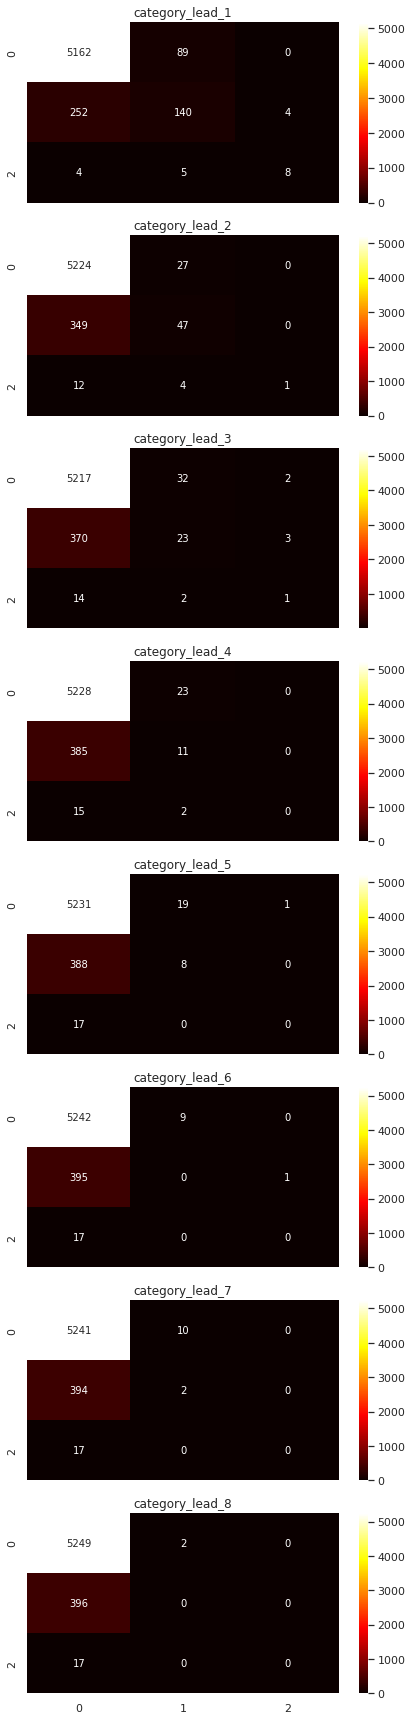

In [20]:
plot_all_confusion_matrices(confusion_matrices, h=3, w=6, annot=True, fmt='.5g', cmap='hot')